## **Task 2a: Event Classification with Masked Transformer Autoencoders**
**Description**:
- Train a Transformer Autoencoder model of your choice on the dataset below using only the first 21 features and only the first 1.1 million events. The last 100k items are to be used as your test set.
- Train a decoder of your choice which uses the latent space outputs of the Transformer encoder layer as inputs.
- Evaluate the performance of the classifier and present a ROC-AUC score for your final classifier.
- For a sense of good performance you can check the original reference paper. https://arxiv.org/pdf/1402.4735.pdf
- Discuss choices made in model selection and optimization.

**Dataset**:

https://archive.ics.uci.edu/dataset/280/higgs (First 1.1 million events)

In [1]:
# Default libraries
import sys
import warnings

# Data preprocessing & visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve,
    confusion_matrix, roc_auc_score
)

# Deep learning
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

# Helper functions & models
sys.path.append('../')
from utils.data_processing import JetsDataset
from utils.custom_loss import MomentumLoss
from utils.training import (
    plot_history, plot_pretrain_tmae_loss, 
    load_checkpoint, pretrain_tmae, inference_histograms,
    train_and_validate, accuracy_metric_bce, test
)
from models.tmae import (
    TransformerMaskedAutoencoder,
    TransformerBinaryClassifier,
    Decoder
)

# Settings
warnings.filterwarnings('ignore')
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### **1. Data Preprocessing**

In [2]:
# Load the data
data = pd.read_csv('../data/HIGGS.csv', header=None, nrows=1_100_000)  # only use the first 1.1M rows

# Split the data into features and labels
X = data.iloc[:, 1:]
y = data.iloc[:, 0]
del data

# Feature names (28)
names = [
    "lepton pT", "lepton eta", "lepton phi", "missing energy magnitude",
    "missing energy phi", "jet 1 pt", "jet 1 eta", "jet 1 phi", "jet 1 b-tag",
    "jet 2 pt", "jet 2 eta","jet 2 phi", "jet 2 b-tag", "jet 3 pt", "jet 3 eta",
    "jet 3 phi", "jet 3 b-tag", "jet 4 pt", "jet 4 eta", "jet 4 phi", "jet 4 b-tag",
    "m_jj", "m_jjj", "m_lv", "m_jlv", "m_bb", "m_wbb", "m_wwbb"
]
X.columns = names
X = X.iloc[:, :21]  # only use the first 21 features
print(X.shape)
X.head()

(1100000, 21)


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,...,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,1.374992,...,0.930349,1.107436,1.138904,-1.578198,-1.046985,0.000000,0.657930,-0.010455,-0.045767,3.101961
1,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,...,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
2,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,...,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
3,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,...,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
4,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,...,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000


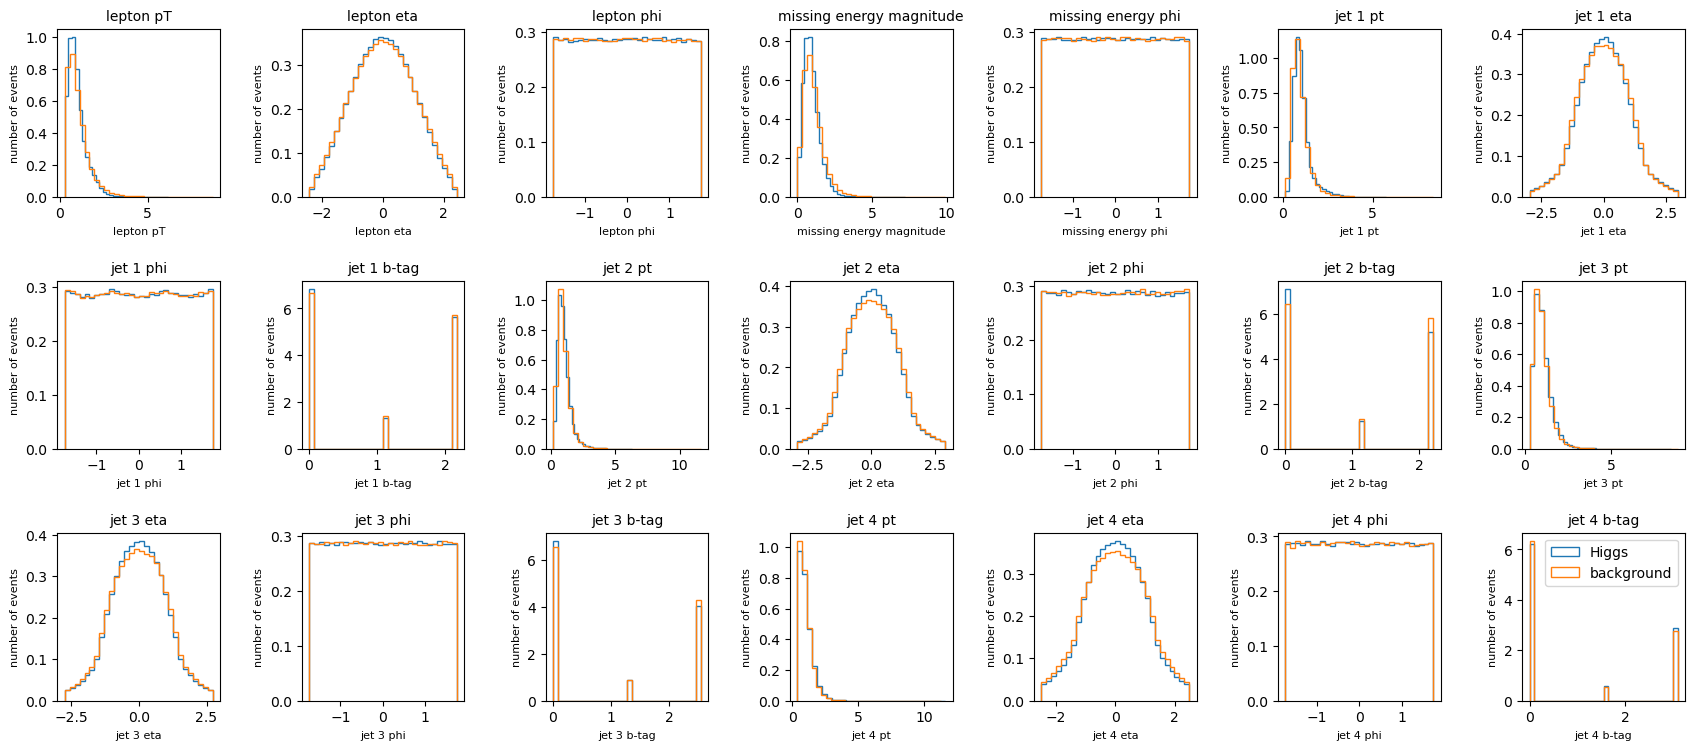

In [3]:
# Generate histograms for each feature
plt.figure(figsize=(21, 12))
class_labels = {1.0: 'Higgs', 0: 'background'}

for index, col in enumerate(X.columns):
    plt.subplot(4, 7, index + 1)
    for class_value, class_name in class_labels.items():
        plt.hist(
            X[y == class_value].iloc[:, index],
            bins=30,
            density=1,
            label=class_name,
            stacked=False,
            histtype='step'
        )
    plt.title(col, fontsize=10)
    plt.xlabel(col, fontsize=8)
    plt.ylabel("number of events", fontsize=8)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.legend(loc='best', fontsize=10)
plt.show()

**Feature Attributes**:

- The columns with b-tag feature are categorical,
- $\eta$ is normally distributed and $\phi$ is uniformly distributed across all lepton and jets,
- Based on the paper, $|\eta| < 2.5$ before scaled,
- All input features are standardized with $\mu = 0$ and $\sigma = 1$, features with values strictly greater than $0$ are scaled to $\mu = 1$.
- Here, you can see that $p_{T} \geq 20 GeV$, $\phi \in [-\pi, \pi]$, and $\eta \in [-2.5, 2.5]$ according to the original paper.
- Because $p_T$ just acts as a scalar, it is OK to keep the scaled values.
- It's possible to undo the scaling to obtain the correct ranges for $\phi$ & $\eta$. However, undo the scaling of $\phi$ from $[-1.74, 1.74]$ to $[-\pi, \pi]$ yielded significantly worse performance, so I kept the scaled values for all of them.

**Citation**:

Baldi, P., Sadowski, P., & Whiteson, D. (2014). [Searching for exotic particles in high-energy physics with deep learning](https://www.nature.com/articles/ncomms5308). *Nature communications*, 5(1), 4308.

In [ ]:
# # Columns for eta and phi
# eta_columns = ['lepton eta', 'jet 1 eta', 'jet 2 eta', 'jet 3 eta', 'jet 4 eta']
# phi_columns = ['lepton phi', 'missing energy phi', 'jet 1 phi', 'jet 2 phi', 'jet 3 phi', 'jet 4 phi']

# # Compute the global min and max for phi columns
# phi_min_global = X[phi_columns].min().min()
# phi_max_global = X[phi_columns].max().max()

# # Scale eta columns
# for col in eta_columns:
#     col_min = X[col].min()
#     col_max = X[col].max()
#     X[col] = (X[col] - col_min) / (col_max - col_min) * 5 - 2.5

# # Scale phi columns: map [phi_min_global, phi_max_global] to [-np.pi, np.pi]
# for col in phi_columns:
#     X[col] = (X[col] - phi_min_global) / (phi_max_global - phi_min_global) * (2 * np.pi) - np.pi
#     X[col] = X[col] - X['lepton phi']  # center around lepton phi
#     X[col] = (X[col] + np.pi) % (2 * np.pi) - np.pi  # wrap around to [-np.pi, np.pi]

# # Generate histograms for each feature after scaling
# plt.figure(figsize=(21, 12))

# for index, col in enumerate(X.columns):
#     plt.subplot(4, 7, index + 1)
#     for class_value, class_name in class_labels.items():
#         plt.hist(
#             X[y == class_value].iloc[:, index],
#             bins=30,
#             density=1,
#             label=class_name,
#             stacked=False,
#             histtype='step'
#         )
#     plt.title(col, fontsize=10)
#     plt.xlabel(col, fontsize=8)
#     plt.ylabel("number of events", fontsize=8)

# plt.subplots_adjust(wspace=0.5, hspace=0.5)
# plt.legend(loc='best', fontsize=10)
# plt.show()

In [4]:
# Split the features and target into train, validation and test sets
X_train, y_train = X[:900_000], y[:900_000]
X_valid, y_valid = X[900_000:1_000_000], y[900_000:1_000_000]
X_test, y_test = X[-100_000:], y[-100_000:]

In [5]:
# Datasets and DataLoaders for classification
train_dataset = JetsDataset(X_train, y_train)
valid_dataset = JetsDataset(X_valid, y_valid)
test_dataset = JetsDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

### **2. Transformer Masked Autoencoder**

In [6]:
# Initialize the encoder
d_model = 256
seq_len = 21
tmae = TransformerMaskedAutoencoder(
    d_model=d_model,
    seq_len=seq_len,
    n_heads=8,
    n_layers=12,
    dropout=0.1
).to(device)
tmae

TransformerMaskedAutoencoder(
  (linear_embedding): Linear(in_features=1, out_features=256, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (recon_head): Linear(in_features=5376, out_features=3, bias=True)
)

- The transformer encoder takes in masked inputs: $p_{T}$, $\eta$, and $\phi$ values of one of the lepton & jets will be masked ($3/21$ input features). Then, it will try to predict the original values with the `recon_head` with $3$ output features. This way, hopefully it'll learn Conservation of Momentum.
- After pretraining, the linear embedding of size $seq\_len \times d_{model}$ will be fed to the decoder for binary classification.

In [7]:
# Hyperparameters for pretraining
lr = 1e-4
num_epochs = 200
beta = 0.5  # coef to encourage eta pred further from 0
gamma = 1.0  # coef for piecewise pT loss
criterion = MomentumLoss(alpha=0.5, reduction='mean')  # alpha*cos_sim(pred, true) + (1-alpha)*MSE(pred, true)
optimizer = optim.Adam(tmae.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
pretrain_history = {
    'epoch': [],
    'train_loss': [],
    'momentum_loss': [],
    'pT_loss': [],
    'eta_loss': [],
    'phi_loss': []
}
checkpoint_path = '../model-checkpoints/Task2a_tmae_checkpoint.pt'
encoder_save_path = '../model-checkpoints/Task2a_encoder.pt'

**References**:

- I obtained valuable insights from the article below, written by Eric Reinhardt, a past participant of GSoC 2023.
- The Medium article greatly summarized the behavior of the dataset and essential equations to obtain momentum components from $p_{T}$, $\eta$, and $\phi$.
$$
p_x = p_T \cos(\phi)
$$

$$
p_y = p_T \sin(\phi)
$$

$$
p_z = p_T \sinh(\eta)
$$
- In addition, because the nature of $\sinh(\eta)$, the model tends to "cheat" by predicting $\eta$ close to $0$ and compensate with more $p_{T}$. This increases $p_x$ and $p_y$ while reducing $p_z$, effectively "conserve" the total momentum of the actual lepton/jets.

[GSOC 2023 with ML4SCI | Reconstruction and Classification of Particle Collisions with Masked Transformer Autoencoders](https://medium.com/@eric0reinhardt/gsoc-2023-with-ml4sci-reconstruction-and-classification-of-particle-collisions-with-masked-bab8b38958df)

**My Approach**:

- I reused Eric's custom loss functions for $p_T$ & $\eta$, they're effective in encouraging the model to predict $\eta$ further from $0$.
- For the circular nature of $\phi$, $-\pi$ & $\pi$ are the same thing, but $MSELoss$ would be huge. To address this feature, I compute the cosine similarity loss for $\phi$ as:
$$
\phi_{loss} = 1 - ( \cos(\phi_{true}) \cdot \cos(\phi_{pred}) + \sin(\phi_{true}) \cdot \sin(\phi_{pred}) )
$$
- Finally, I have the custom $MomentumLoss$ function to learn the differences between the predicted and true momentum vectors of the particles:
$$
p_{loss} = \alpha \cdot \left( 1 - \frac{\vec{p}_{pred} \cdot \vec{p}_{true}}{\| \vec{p}_{pred} \| \| \vec{p}_{true} \|} \right) + (1 - \alpha) \cdot \text{MSE} \left( \| \vec{p}_{pred} \|, \| \vec{p}_{true} \| \right)
$$,
Where:
$$
\vec{p}_{pred} = 
\begin{bmatrix}
p_{T \, pred} \cdot \cos(\phi_{pred}) \\
p_{T \, pred} \cdot \sin(\phi_{pred}) \\
p_{T \, pred} \cdot \sinh(\eta_{pred})
\end{bmatrix}
\quad \text{and} \quad
\vec{p}_{true} = 
\begin{bmatrix}
p_{T \, true} \cdot \cos(\phi_{true}) \\
p_{T \, true} \cdot \sin(\phi_{true}) \\
p_{T \, true} \cdot \sinh(\eta_{true})
\end{bmatrix}
$$
The final loss is averaged over the batch. The purpose of this loss function is to prevent the model cheating by balancing $p_x$, $p_y$, and $p_z$. The undesired behavior is that the encoder increases $p_T$ to compensate for small $\eta$ results in higher $p_x$, $p_y$ and lower $p_z$. This trade-off *might* conserve the magnitude of $p_{true}$, but $p_{pred}$ would point in a completely different direction, causing the cosine similarity term in the loss function to increase.

In [ ]:
# Pretrain the encoder
pretrain_history, tmae = pretrain_tmae(
    model=tmae,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    beta=beta,
    gamma=gamma,
    history=pretrain_history,
    checkpoint_path=checkpoint_path,
    best_model_path=encoder_save_path
)

Pretrain Epoch [1/200], Component Losses: (pT=1.1772, eta=0.7991, phi=0.3107), Momentum Loss: 0.9531, Reconstruction Loss: 3.2400
Pretrain Epoch [2/200], Component Losses: (pT=1.1115, eta=0.7693, phi=0.2333), Momentum Loss: 0.8533, Reconstruction Loss: 2.9674
Pretrain Epoch [3/200], Component Losses: (pT=1.1008, eta=0.7495, phi=0.2250), Momentum Loss: 0.8307, Reconstruction Loss: 2.9060
Pretrain Epoch [4/200], Component Losses: (pT=1.0960, eta=0.7413, phi=0.2229), Momentum Loss: 0.8209, Reconstruction Loss: 2.8812
Pretrain Epoch [5/200], Component Losses: (pT=1.0936, eta=0.7357, phi=0.2190), Momentum Loss: 0.8173, Reconstruction Loss: 2.8656
Pretrain Epoch [6/200], Component Losses: (pT=1.0910, eta=0.7313, phi=0.2183), Momentum Loss: 0.8102, Reconstruction Loss: 2.8507
Pretrain Epoch [7/200], Component Losses: (pT=1.0887, eta=0.7265, phi=0.2168), Momentum Loss: 0.8020, Reconstruction Loss: 2.8340
Pretrain Epoch [8/200], Component Losses: (pT=1.0865, eta=0.7255, phi=0.2156), Momentum Lo

In [19]:
# Load the checkpoint
start_epoch, pretrain_history, tmae = load_checkpoint(
    checkpoint_path=checkpoint_path,
    model=tmae,
    optimizer=optimizer,
    scheduler=scheduler,
)

Loaded checkpoint from epoch 137


In [20]:
# Pretrain the encoder
pretrain_history, tmae = pretrain_tmae(
    model=tmae,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    start_epoch=start_epoch,
    beta=beta,
    gamma=gamma,
    history=pretrain_history,
    checkpoint_path=checkpoint_path,
    best_model_path=encoder_save_path
)

Pretrain Epoch [138/200], Component Losses: (pT=1.0681, eta=0.6572, phi=0.2005), Momentum Loss: 0.7453, Reconstruction Loss: 2.6710
Pretrain Epoch [139/200], Component Losses: (pT=1.0682, eta=0.6583, phi=0.2006), Momentum Loss: 0.7502, Reconstruction Loss: 2.6772
Pretrain Epoch [140/200], Component Losses: (pT=1.0678, eta=0.6538, phi=0.1990), Momentum Loss: 0.7459, Reconstruction Loss: 2.6664
Pretrain Epoch [141/200], Component Losses: (pT=1.0682, eta=0.6570, phi=0.2004), Momentum Loss: 0.7478, Reconstruction Loss: 2.6735
Pretrain Epoch [142/200], Component Losses: (pT=1.0688, eta=0.6568, phi=0.1993), Momentum Loss: 0.7493, Reconstruction Loss: 2.6743
Pretrain Epoch [143/200], Component Losses: (pT=1.0679, eta=0.6576, phi=0.1996), Momentum Loss: 0.7468, Reconstruction Loss: 2.6720
Pretrain Epoch [144/200], Component Losses: (pT=1.0680, eta=0.6559, phi=0.2004), Momentum Loss: 0.7433, Reconstruction Loss: 2.6677
Pretrain Epoch [145/200], Component Losses: (pT=1.0676, eta=0.6557, phi=0.20

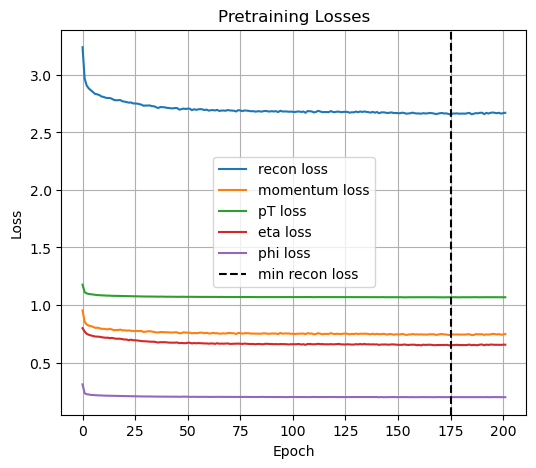

In [ ]:
# Visualize the pretraining loss
plot_pretrain_tmae_loss(pretrain_history)

In [8]:
# Load the checkpoint for the encoder
tmae.load_state_dict(torch.load(encoder_save_path))

<All keys matched successfully>

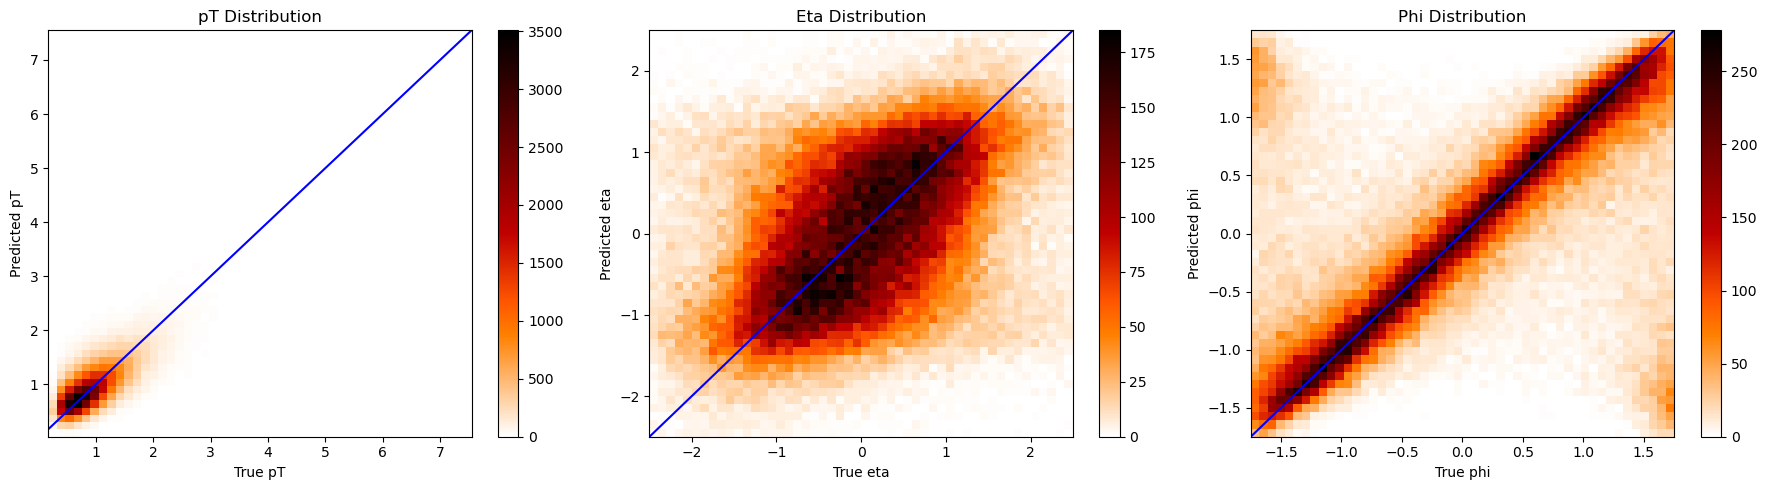

In [9]:
# Visualize the performance of the pretrained encoder
inference_histograms(tmae, valid_loader, seq_len=21)

- Here, you can see that the predictions of the encoder resemble the desired behaviors mentioned in the article.
- For $\phi$, the predictions follow a uniform distribution just like their true values while realizing the symmetry of the detector (top left and bottom right).
- Although the predictions for $\eta$ are far from perfect, the model no longer cheat by concentrating its predicted values in $[-1, 1]$. You can see the predictions have a normal distribution with similar mean and standard deviation compared to the targets.

### **3. Decoders Fine-Tuning**

#### **Feedforward Decoder**

In [10]:
# Initialize the feedforward classifier
feedforward_classifier = Decoder(input_size=seq_len*d_model, hidden_dim=300, drop_out=0.25).to(device)
feedforward_classifier

Decoder(
  (linear1): Linear(in_features=5376, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=300, bias=True)
  (linear4): Linear(in_features=300, out_features=300, bias=True)
  (linear5): Linear(in_features=300, out_features=300, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=300, out_features=1, bias=True)
)

In [11]:
# Hyperparameters for training the classifier
lr = 1e-4
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(feedforward_classifier.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
fine_tuned_encoder_ff_save_path = '../model-checkpoints/Task2a_fine_tuned_encoder_ff.pt'
feedforward_decoder_save_path = '../model-checkpoints/Task2a_ff_decoder.pt'

In [12]:
# Train the classifier
history, feedforward_classifier = train_and_validate(
    model=(tmae, feedforward_classifier),
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    metric=accuracy_metric_bce,
    scheduler=scheduler,
    num_epochs=num_epochs,
    save_path=[fine_tuned_encoder_ff_save_path, feedforward_decoder_save_path],
    save_strategy='val_loss',  # can be 'val_loss' or 'val_acc'
    train_decoder=True
)

Epoch [1/50], Train Loss: 0.5979, Train Metric: 0.6744, Val Loss: 0.5693, Val Metric: 0.7029
Epoch [2/50], Train Loss: 0.5686, Train Metric: 0.7051, Val Loss: 0.5566, Val Metric: 0.7150
Epoch [3/50], Train Loss: 0.5592, Train Metric: 0.7122, Val Loss: 0.5500, Val Metric: 0.7195
Epoch [4/50], Train Loss: 0.5535, Train Metric: 0.7168, Val Loss: 0.5465, Val Metric: 0.7208
Epoch [5/50], Train Loss: 0.5486, Train Metric: 0.7210, Val Loss: 0.5446, Val Metric: 0.7237
Epoch [6/50], Train Loss: 0.5447, Train Metric: 0.7235, Val Loss: 0.5420, Val Metric: 0.7256
Epoch [7/50], Train Loss: 0.5414, Train Metric: 0.7264, Val Loss: 0.5407, Val Metric: 0.7251
Epoch [8/50], Train Loss: 0.5383, Train Metric: 0.7285, Val Loss: 0.5380, Val Metric: 0.7267
Epoch [9/50], Train Loss: 0.5354, Train Metric: 0.7304, Val Loss: 0.5362, Val Metric: 0.7298
Epoch [10/50], Train Loss: 0.5328, Train Metric: 0.7323, Val Loss: 0.5353, Val Metric: 0.7306
Epoch [11/50], Train Loss: 0.5304, Train Metric: 0.7343, Val Loss: 0.

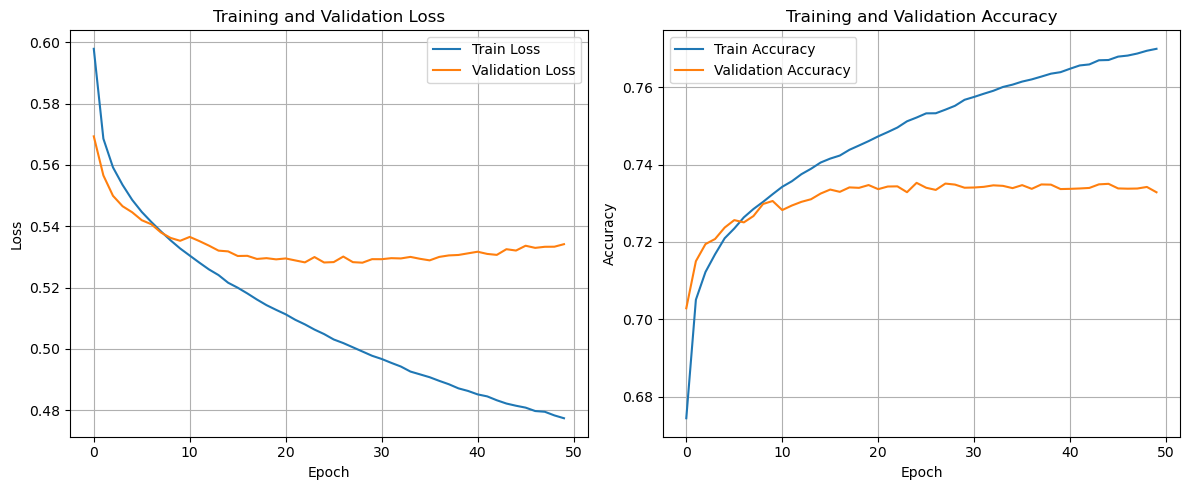

In [13]:
# Plot the training history
plot_history(history)

In [12]:
# Load the checkpoint with the best validation loss for the classifier
tmae.load_state_dict(torch.load(fine_tuned_encoder_ff_save_path))
feedforward_classifier.load_state_dict(torch.load(feedforward_decoder_save_path))

<All keys matched successfully>

Test Loss: 0.5279, Test Metric: 0.7368, ROC AUC: 0.8103


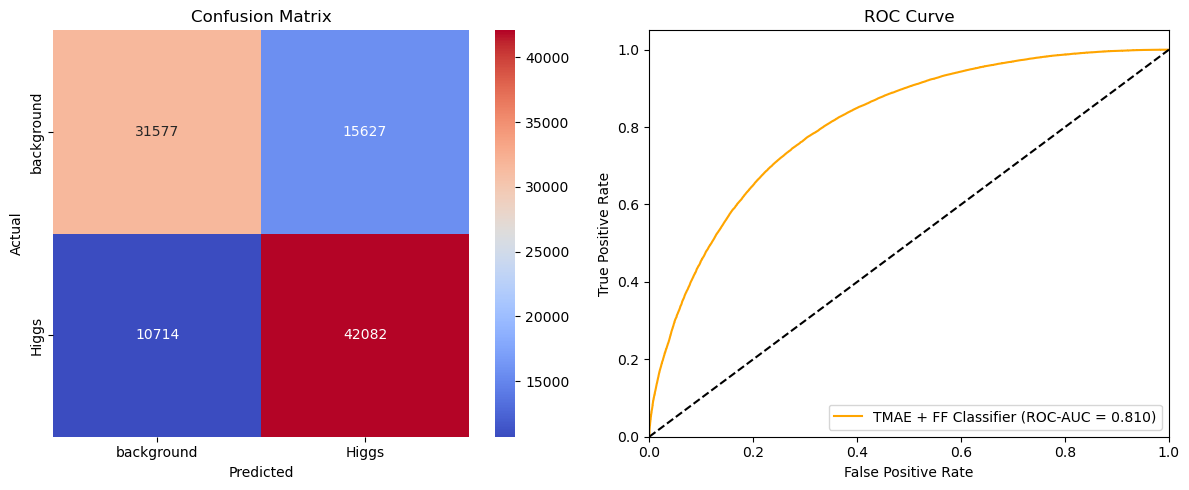

In [13]:
# Evaluate the classifier
test(
    model=(tmae, feedforward_classifier),
    test_loader=test_loader,
    criterion=criterion,
    metric=accuracy_metric_bce,
    train_decoder=True,
    model_name="TMAE + FF Classifier",
    classes=['background', 'Higgs']
)

#### **Transformer Decoder**

In [14]:
# Load the checkpoint for the encoder
tmae.load_state_dict(torch.load(encoder_save_path))

<All keys matched successfully>

In [15]:
# Initialize the transformer binary classifier
transformer_classifier = TransformerBinaryClassifier(
    d_model=d_model,
    seq_len=seq_len,
    n_heads=8,
    n_layers=12,
    dropout=0.1
).to(device)
transformer_classifier

TransformerBinaryClassifier(
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
        (dropout3): Dropout(p=0.1, inplace=False)
   

In [16]:
# Hyperparameters for training the classifier
lr = 1e-4
num_epochs = 50
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(feedforward_classifier.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.96)
fine_tuned_encoder_t_save_path = '../model-checkpoints/Task2a_fine_tuned_encoder_t.pt'
transformer_decoder_save_path = '../model-checkpoints/Task2a_t_decoder.pt'

In [ ]:
# Train the classifier
history, transformer_classifier = train_and_validate(
    model=(tmae, transformer_classifier),
    train_loader=train_loader,
    val_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer,
    metric=accuracy_metric_bce,
    scheduler=scheduler,
    num_epochs=num_epochs,
    save_path=[fine_tuned_encoder_t_save_path, transformer_decoder_save_path],
    save_strategy='val_loss',  # can be 'val_loss' or 'val_acc'
    train_decoder=True
)

Epoch [1/50], Train Loss: 0.6222, Train Metric: 0.6478, Val Loss: 0.5860, Val Metric: 0.6893
Epoch [2/50], Train Loss: 0.5815, Train Metric: 0.6919, Val Loss: 0.5687, Val Metric: 0.7045
Epoch [3/50], Train Loss: 0.5695, Train Metric: 0.7029, Val Loss: 0.5605, Val Metric: 0.7104
Epoch [4/50], Train Loss: 0.5605, Train Metric: 0.7105, Val Loss: 0.5530, Val Metric: 0.7175
Epoch [5/50], Train Loss: 0.5533, Train Metric: 0.7163, Val Loss: 0.5489, Val Metric: 0.7200
Epoch [6/50], Train Loss: 0.5481, Train Metric: 0.7208, Val Loss: 0.5431, Val Metric: 0.7238
Epoch [7/50], Train Loss: 0.5440, Train Metric: 0.7232, Val Loss: 0.5405, Val Metric: 0.7250
Epoch [8/50], Train Loss: 0.5402, Train Metric: 0.7263, Val Loss: 0.5389, Val Metric: 0.7272
Epoch [9/50], Train Loss: 0.5367, Train Metric: 0.7285, Val Loss: 0.5361, Val Metric: 0.7288
Epoch [10/50], Train Loss: 0.5340, Train Metric: 0.7309, Val Loss: 0.5349, Val Metric: 0.7289
Epoch [11/50], Train Loss: 0.5314, Train Metric: 0.7323, Val Loss: 0.

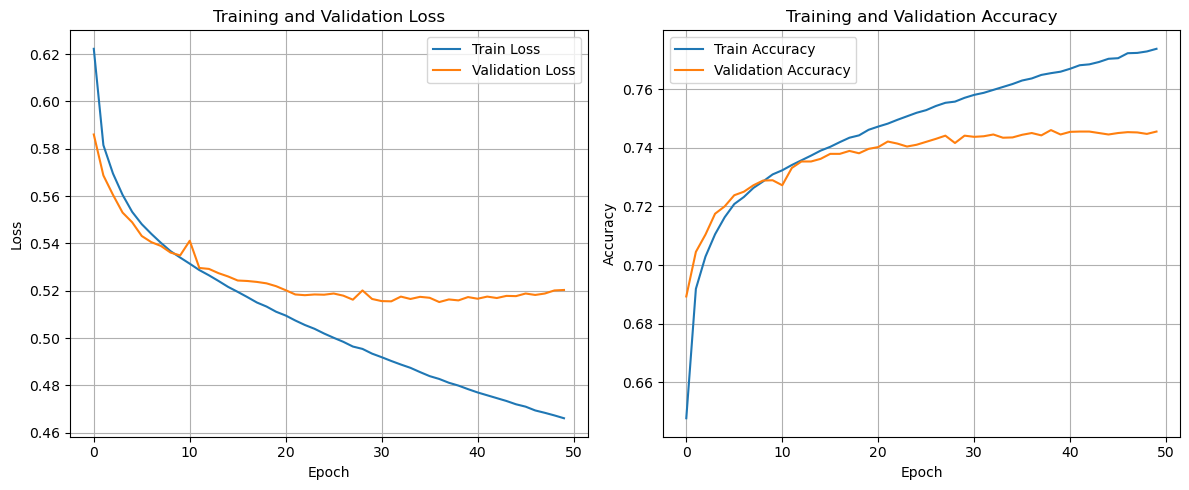

In [22]:
# Plot the training history
plot_history(history)

In [17]:
# Load the checkpoint with the best validation loss for the classifier
tmae.load_state_dict(torch.load(fine_tuned_encoder_t_save_path))
transformer_classifier.load_state_dict(torch.load(transformer_decoder_save_path))

<All keys matched successfully>

Test Loss: 0.5129, Test Metric: 0.7471, ROC AUC: 0.8240


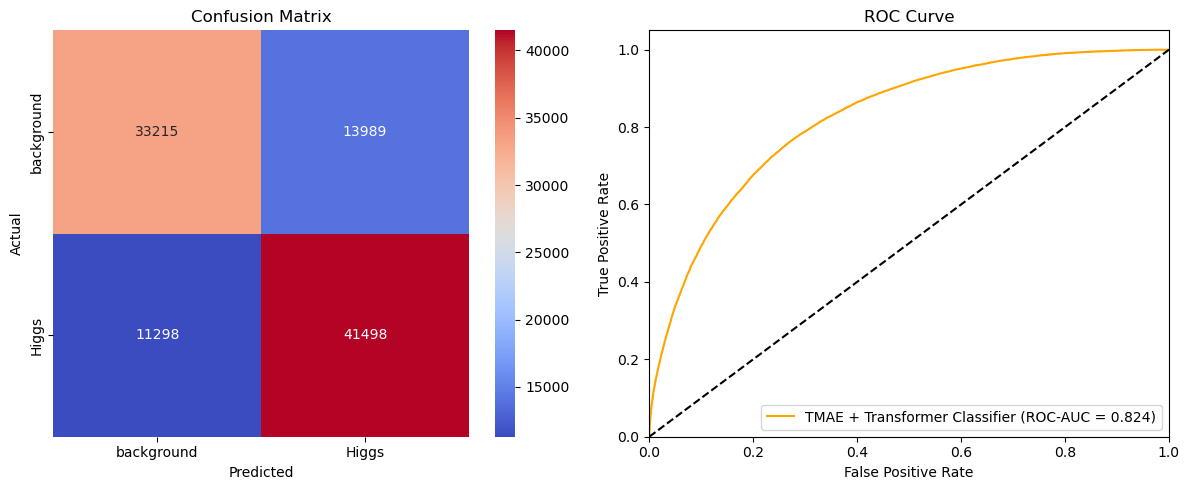

In [18]:
# Evaluate the classifier
test(
    model=(tmae, transformer_classifier),
    test_loader=test_loader,
    criterion=criterion,
    metric=accuracy_metric_bce,
    train_decoder=True,
    model_name="TMAE + Transformer Classifier",
    classes=['background', 'Higgs']
)

- This is the best result I'm able to achieve: `0.824 AUC` with Transformer Decoder trained on the latent space output of the Transformer Encoder.

#### **XGBoost for Comparison**

In [19]:
# Define functions for confusion matrix and ROC curve
def plot_result(model, true: pd.Series, pred: np.ndarray, prob: np.ndarray, classes: list[str]):
    print(accuracy_score(true, pred))

    cm = confusion_matrix(true, pred)
    fpr, tpr, _ = roc_curve(true, prob)
    auc = roc_auc_score(true, prob)

    plt.figure(figsize=(12, 5))

    # Confusion matrix
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, color='orange', label=f'{model}, {auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

0.7223766666666667


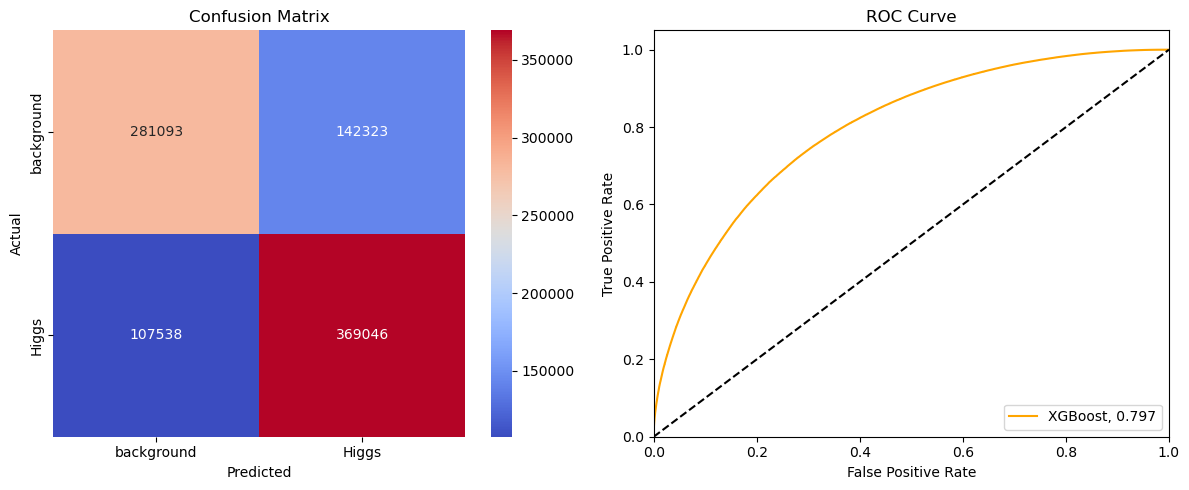

In [20]:
# Fit the XGBoost model
xgb = XGBClassifier(
    n_estimators=1000,
    max_depth=6,
    grow_policy='lossguide',
    learning_rate=0.1,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42
)
xgb.fit(X_train, y_train)

# Prediction on the training set
y_pred_train = xgb.predict(X_train)
y_prob_train = xgb.predict_proba(X_train)[:, 1]

# Visualize the results of training set
plot_result('XGBoost', y_train, y_pred_train, y_prob_train, classes=['background', 'Higgs'])

0.68287


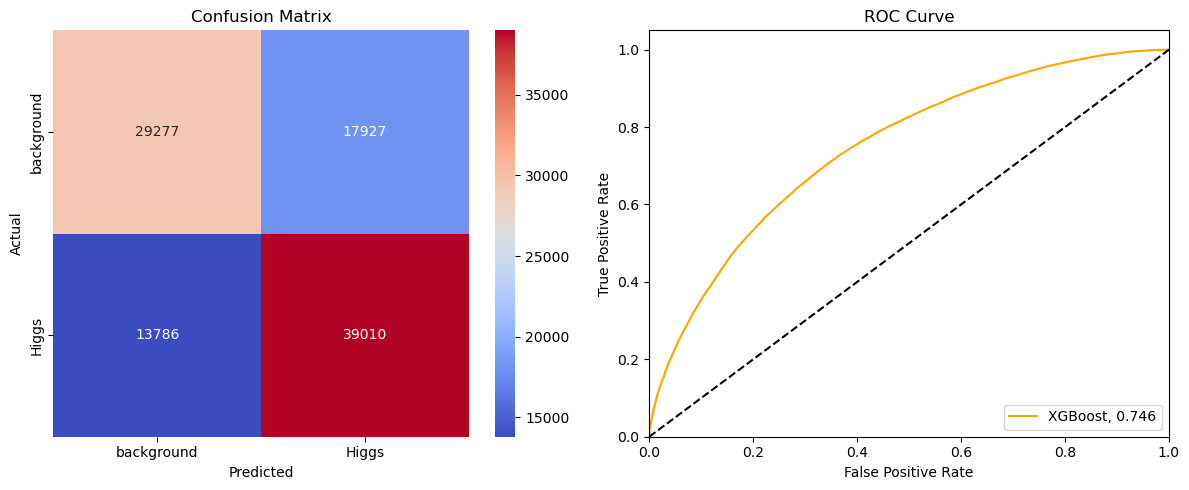

In [21]:
# Prediction on the test set
xgb_pred_val = xgb.predict(X_test)
xgb_pred_prob_val = xgb.predict_proba(X_test)

# Visualize the results of test set
plot_result("XGBoost", y_test, xgb_pred_val, xgb_pred_prob_val[:, 1], classes=['background', 'Higgs'])

- XGBoost, popular and powerful model for tabular data, did not perform as well when trained on $900000$ instances.